# Programming evaluation 1
Fill in the following cells as indicated. If you do not know what specific python code should be used (i.e. if you forgot a function or package name, or otherwise don't remember the precise form of the code necessary to accomplish a task), please write out a description of what needs to be done in pseudo-code or plain English. Comments describing what your code is doing are also strongly encouraged, especially if you are not sure that your code is correct. For example:

```python
# These line constructs a random normal array that is size (100 time points x 50 voxels)
n_voxels = 50
n_timepoints = 100
Y = np.random.randn((n_timepoints, n_voxels))
```

The above line won't actually run correctly due to an error in the code, but would be worth 90% of the points for that component of the question.

Finally, if aren't sure that you are doing something the way we have done it in class, or thin your solution might be imperfect, that's OK - if your hacky or imperfect solution works, you may get full points, and you will get partial credit for trying something even if it doesn't.

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import cortex as cx
import h5py

# Make image plots easier
plt.rcParams['image.aspect'] = 'auto'

# Some utility functions
import sys
import os
sys.path.append(os.path.abspath('..'))
import utils.fmri as fmriutils

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Part 1: construction of arrays & fake data

> `1. (5 points)` Construct a design matrix (Call it X) consisting of five columns of binary indicator variables that is 200 TRs long (1 point). Each column should have five occurrences of a condition, each coded as series of ones in the array (1 point), and each condition occurrence should last 2 TRs(1 point). No two conditions should ever be on at the same time (1 point).  Once you have constructed this array, show it using plt.imshow() (1 point) Please attempt to construct this array as instructed, but if you have trouble, please simply make a random array of the same size (200 TRs by 5 conditions) to use in the next questions.

[  4  12  23  31  37  45  55  62  71  75  86  92  99 109 113 124 132 138
 148 153 165 174 179 189 196]
[[ 86  45  31 174  55]
 [ 99 148  71 196 124]
 [109  92  62 179 113]
 [165  75 153 132  23]
 [  4  12 189  37 138]]


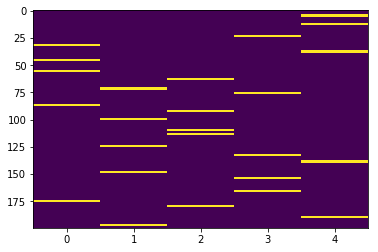

In [6]:
# Answer
n_tps = 200
n_conditions = 5
n_onsets_per_condition = 5
cond_duration = 2
# The part about making sure no two conditions are on at the same time
# was a bit tricky. If you hand-coded this, that's fine. This is a way
# to do this that is guaranteed not to overlap. This is not something
# we've explicitly covered in this class, but it's certainly a problem
# you might come across in your research. Just requires a bit of 
# creativity with the functions we know about. All the things labeled 
# "Fancy" are extras to make this more like a real experiment.

# Acceptable way
n_onsets_total = n_conditions * n_onsets_per_condition
onsets = np.linspace(5, 195, n_onsets_total)
# Fancy: Jitter the onsets a little, just for funsies
jitter = np.random.uniform(low=-3, high=3, size=(len(onsets)))
onsets = onsets + jitter
# Convert to integers (since these are indices)
onsets = np.floor(onsets).astype(np.int)
print(onsets)

# Fancy: Choose randomly which condition is on when
onset_idx = np.random.permutation(range(n_onsets_total))
onsets = onsets[onset_idx]
onsets = np.reshape(onsets, (n_conditions, -1))
print(onsets)

# Initialize X, proceed
X = np.zeros((n_tps, n_conditions))
for condition in range(n_conditions):
    for cond_onset in onsets[condition, :]:
        X[cond_onset:cond_onset+cond_duration, condition] = 1

# Show X
plt.imshow(X)

# Note: No two are on at the same time.

In [7]:
# Quick convolution of the data with an HRF function
t, hrf = fmriutils.hrf()
Xc = np.zeros(X.shape)
for column in range(5):
    tmp = np.convolve(X[:,column], hrf)
    Xc[:,column] = tmp[:X.shape[0]]

> `2. (1 point)` Why is it necessary to clip the `tmp` variable above to a maximum length of X.shape[0]? (this answer is just written)

Answer:

The convolution adds the length of the hrf to the end of the X variable, which we don't want, because then the length of X will not match the length of Y. Thus, clip it.

> `3. (3 points)` Create an array of random normal weights (call it `B`), one for each condition in the array above for each of 30 voxels (1 point). Multiply the array of weights by the HRF-convolved design matrix (`Xc`) to generate an array of data (call it `Y`) (1 point), and add some noise to Y. (1 point)

In [10]:
# Answer
n_voxels = 30
B = np.random.randn(n_conditions, n_voxels)
noise_magnitude = 0.3
noise = np.random.randn(n_tps, n_voxels) * noise_magnitude
Y = X.dot(B) + noise

> `4. (3 points)` Use ordinary least squares regression to estimate the weights from the noisy data (2 points). The normal equation for ordinary least squares is: $B = (X^TX)^{-1}X^TY$ Show the weights are close to the original weights however you can (1 point)

0.10074831810849842


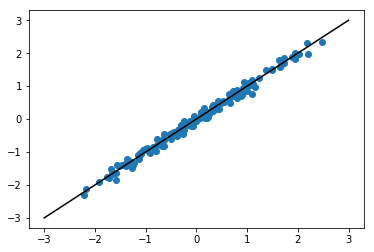

In [18]:
# Answer
def ols(X, Y):
    B = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(Y))
    return B

B_est = ols(X, Y)

# Show that they are close
# Plot unity line
xy = np.linspace(-3, 3, 100)
plt.plot(xy, xy, 'k')
# Plot B vs B_est
plt.scatter(B, B_est)
# The fact that these are on a diagonal (y=x) indicates that they are close.

# Or: 
B_err = np.std(B-B_est)
# Average deviation from zero for the difference of B - B_est
print(B_err)

> `5. (3 points)` The experiment above is a simulation of a traditional block design or event-related experiment, a la Karl Friston. Describe in words or code what it would take to make this simulation into an encoding model experiment. Specifically: what would be different about X? (1 point) What might be different about the regression and why? (1 point) A critical aspect of the encoding model framework is making predictions of withheld data. What would this involve, in this sort of simulation? (1 point)

Answer 

In an encoding model experiment, there are generally more parameters to describe the stimulus. Thus, X would have more columns. The columns might also take continuous values instead of indicator (1 or 0) values (though that's not strictly necessary). 

The regression might need to be ridge regression instead of OLS, to better support estimating a large number of features.

To support prediction of withheld data, the X and Y variables would have been divided in some way into fit and test sets. 


## Part 2: writing functions
Another of the tasks we've done several times in class is to put a formula into python code. Here, your task is to write a function that computes the Euclidean distance between two vectors. The Euclidean distance is: 

## $D = \sqrt{(x_1-y_1)^2 + (x_2-y_2)^2 + ... + (x_n-y_n)^2}$

or, more generally, 

## $D = \sqrt{\sum_{i=1}^n (x_i-y_i)^2)}$

$n$ is the number of elements in each vector; $x$ and $y$ are the vectors. 

> `6. (3 points)` Write a function that computes the Euclidean distance between two vectors (2 points). Use that function to compute the distance between each pair the three vectors (a, b, and c) below and show the distance between each pair however you see fit (1 point)

In [19]:
# load data
rand_data = np.load('random_vars.npz')
a = rand_data['a']
b = rand_data['b']
c = rand_data['c']
print(a.shape, b.shape, c.shape)

(100,) (100,) (100,)


In [22]:
# Answer
# Define the function
def euclidean_dist(x, y): 
    dst = np.sqrt(np.sum((x-y)**2))
    return dst

# Use the function to compute distances btw pairs of variables ((a,b), etc )
dst_ab = euclidean_dist(a, b)
dst_bc = euclidean_dist(b, c)
dst_ac = euclidean_dist(a, c)
print(dst_ab)
print(dst_bc)
print(dst_ac)

13.976375103675357
3.2333941440701635
14.692589898993276


## Part 3: array masking
> `7. (1 point)` How many voxels are in the following mask for V4? (you will have to do something to the array to find out)

In [24]:
subject = 's01'
transform = 'color_natims'
roi_mask = cx.get_roi_masks(subject, transform, roi_list=['V4'])

Cutting 0 overlapping voxels (should be < ~50)


In [25]:
# Answer
n_voxels = roi_mask['V4'].sum()
print(n_voxels)

367


> `8. (1 point)` Use the mask to select all voxels in V4 in the val_brain data array. Show the shape of the resulting array.

In [26]:
# Load val_brain
with h5py.File('/unrshare/LESCROARTSHARE/IntroToEncodingModels/s01_color_natims_data.hdf') as hf:
    val_data = hf['val'].value
    mask = hf['mask'].value
val_brain = np.zeros((val_data.shape[0],) + mask.shape)
val_brain[:, mask] = val_data

In [27]:
# Answer 
V4_voxels = val_brain[:, roi_mask['V4']]
print(V4_voxels.shape)

(126, 367)


## Part 4: (Bonus, extra credit) data visualization
The following 3D array (`d`) contains a mask for a 3D shape within it (ones where the shape is present, 0 where it is absent). 

> `9. (+ 3 points)` Use the `plt.imshow()` (or `ax.imshow()`) function to visualize 3 different slices through the array in each of the 3 dimensions of the array. Thus, you should make a total of 9 plots (or subplots, if you want to be fancy - not required). These plots are analogous to looking at transverse, saggital, and coronal sections of a brain. (To be clear, a slice involves specifying a value for one dimension, and showing all values for the other dimensions. For each dimension, I recommend showing the 30th, 50th, and 70th values). 

In [28]:
d = np.load('mystery_shape.npy')
print(d.shape)

(100, 100, 100)


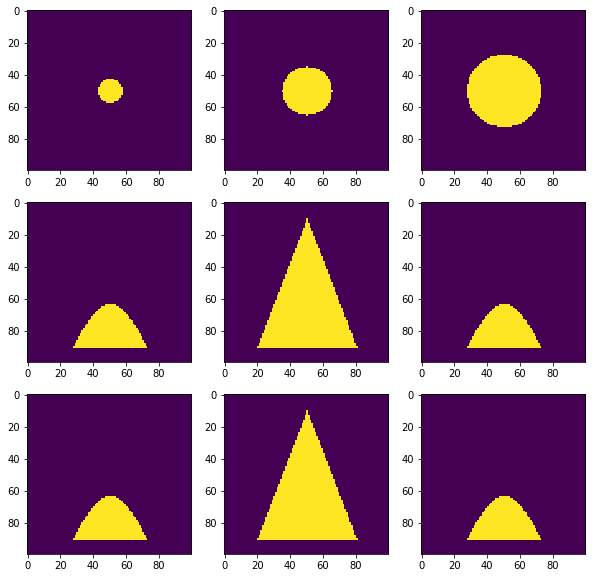

In [30]:
# Answer
fig, axs = plt.subplots(3, 3, figsize=(10,10))
indices = [30, 50, 70]
# Slice in first dim
for j, idx in enumerate(indices):
    axs[0,j].imshow(d[idx, :, :])
# Slice in second dim
for j, idx in enumerate(indices):
    axs[1,j].imshow(d[:, idx, :])
# Slice in third dim
for j, idx in enumerate(indices):
    axs[2,j].imshow(d[:, :, idx])


> `10. (+ 1 point)` What is the 3D shape? 

Answer: 

It's a cone.